In [23]:
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import pandas as pd 
from lexical_richness_utility import analyze_lexical_richness
from text_analysis import *
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Background

#### The notebook contains code that builds a mlp neural network that predicts if text is AI generated or not.

In [24]:
training_data = pd.read_csv("training_data.csv")

# EDA

In [25]:
print('dataset has',training_data.shape[0],'rows and',training_data.shape[1],'columns.')

dataset has 86587 rows and 2 columns.


In [26]:
percent_missing = training_data.isnull().sum() * 100 / len(training_data)
missing_value_df = pd.DataFrame({'column_name': training_data.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
text,text,0.0
label,label,0.0


In [27]:
training_data.dtypes

text     object
label     int64
dtype: object

In [28]:
training_data.label.value_counts()

0    55845
1    30742
Name: label, dtype: int64

# DATA PREPARATION

In [29]:
training_data['sentence_count'] = training_data['text'].apply(count_sentences)

In [30]:
training_data['declarative_sentence_count'] = training_data['text'].apply(count_declarative_sentences)
training_data['interrogative_sentence_count'] = training_data['text'].apply(count_interrogative_sentences)
training_data['exclamatory_sentence_count'] = training_data['text'].apply(count_exlamatory_sentences)

In [31]:
training_data['text'] = training_data['text'].apply(remove_punctuation_and_lowercase)

In [32]:
training_data['sentiment_class'] = training_data['text'].apply(get_sentiment_label)

In [33]:
training_data['word_count'] = training_data['text'].apply(count_words)

In [34]:
training_data['verb_count'] = training_data['text'].apply(count_verbs)

In [35]:
training_data['entity_count'] = training_data['text'].apply(entity_count)

In [36]:
training_data['lexical_richness_score'] = training_data['text'].apply(analyze_lexical_richness)

In [37]:
training_data = training_data.fillna(0)

In [38]:
training_data[['sentence_count', 'declarative_sentence_count', 'interrogative_sentence_count', 'word_count', 'verb_count','entity_count','lexical_richness_score']].describe()

,sentence_count,declarative_sentence_count,interrogative_sentence_count,word_count,verb_count,entity_count,lexical_richness_score
count,86587.000000,86587.000000,86587.000000,86587.000000,86587.000000,86587.000000,86587.000000
mean,21.321145,19.606442,0.643330,388.540624,77.017947,7.835587,0.523839
std,9.195264,9.042488,1.427633,167.173904,35.103562,8.060340,0.136939
min,1.000000,0.000000,0.000000,42.000000,6.000000,0.000000,0.016986
25%,15.000000,14.000000,0.000000,275.000000,53.000000,2.000000,0.430845
50%,20.000000,18.000000,0.000000,359.000000,70.000000,5.000000,0.504923
75%,26.000000,24.000000,1.000000,463.000000,92.000000,11.000000,0.601553
max,136.000000,112.000000,26.000000,1371.000000,302.000000,85.000000,1.148756


<Figure size 1200x400 with 0 Axes>

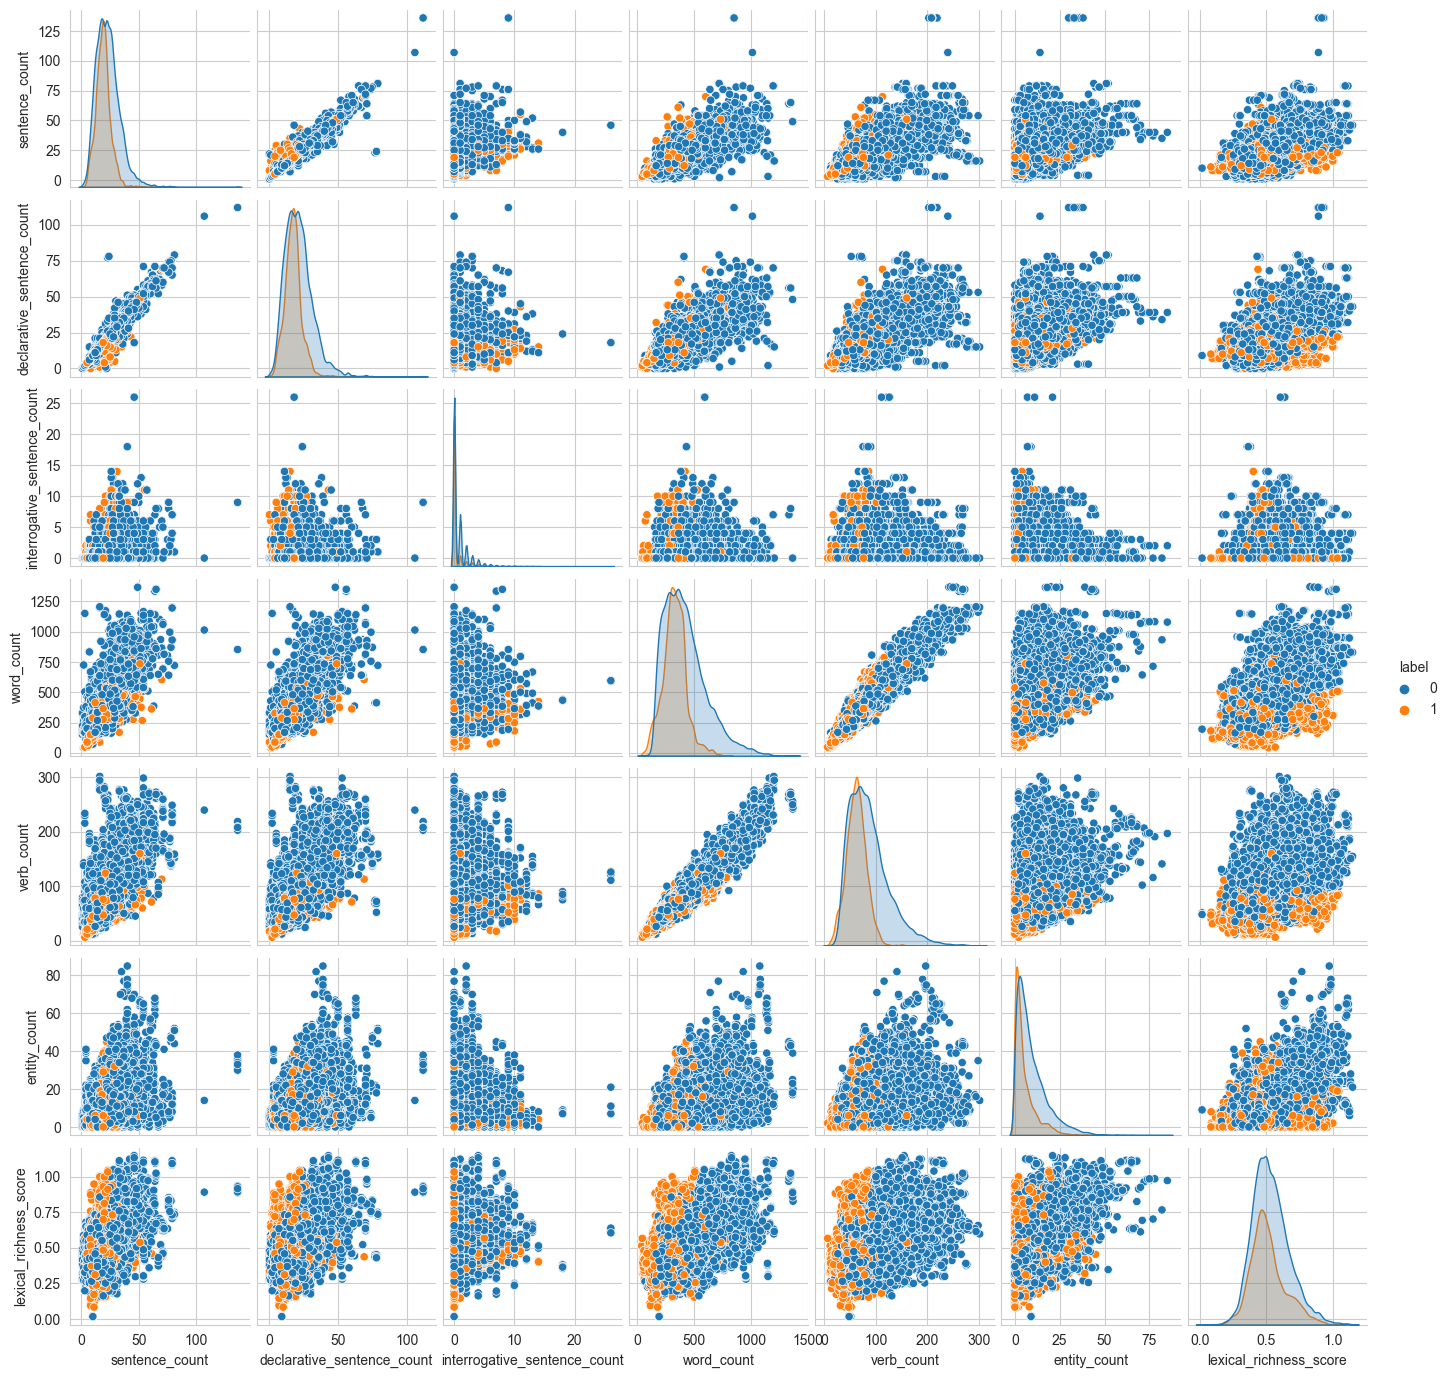

In [39]:
training_data = training_data.loc[:, ~training_data.columns.duplicated()]
required_columns = ['sentence_count', 'declarative_sentence_count', 'interrogative_sentence_count', 'word_count', 'verb_count', 'label','entity_count','lexical_richness_score']
missing_columns = [col for col in required_columns if col not in training_data.columns]
if missing_columns:
    raise ValueError(f"Missing columns in DataFrame: {missing_columns}")
training_data_cleaned = training_data.dropna(subset=required_columns)
training_data_cleaned['label'] = training_data_cleaned['label'].astype('category')
plt.figure(figsize=(12, 4))
sns.set_style('whitegrid')
sns.pairplot(training_data_cleaned[required_columns], height=2, hue='label')
plt.show()


In [40]:
training_data = pd.get_dummies(training_data, columns=["sentiment_class"]) 

In [41]:
percent_missing = training_data.isnull().sum() * 100 / len(training_data)
missing_value_df = pd.DataFrame({'column_name': training_data.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
text,text,0.0
label,label,0.0
sentence_count,sentence_count,0.0
declarative_sentence_count,declarative_sentence_count,0.0
interrogative_sentence_count,interrogative_sentence_count,0.0
exclamatory_sentence_count,exclamatory_sentence_count,0.0
word_count,word_count,0.0
verb_count,verb_count,0.0
entity_count,entity_count,0.0
lexical_richness_score,lexical_richness_score,0.0


# MODELLING

In [42]:
# Split data into features and target
X = training_data.drop(["label","text"], axis=1)
y = training_data["label"]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize and train the MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=1000, random_state=42)
mlp_classifier.fit(X_train_resampled, y_train_resampled)

MLPClassifier(max_iter=1000, random_state=42)

# EVALUATION

In [43]:
# Make predictions
y_pred = mlp_classifier.predict(X_test)
pred = mlp_classifier.predict(X_train)
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, pred)
print(f'training accuracy: {train_accuracy:.2f}')
print(f'test accuracy: {test_accuracy:.2f}')
report = classification_report(y_test, y_pred)
print("\nClassification Report:\n")
print(report)

training accuracy: 0.84
test accuracy: 0.83

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.82      0.86     11104
           1       0.72      0.86      0.78      6214

    accuracy                           0.83     17318
   macro avg       0.82      0.84      0.82     17318
weighted avg       0.84      0.83      0.83     17318



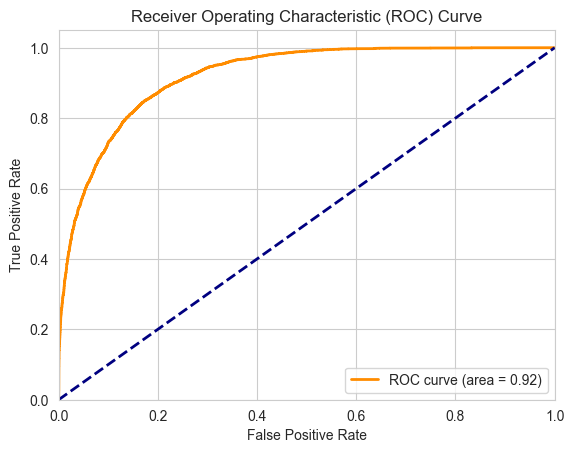

In [44]:
y_prob = mlp_classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()